In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data_folder = '../car_hacking_data/'
print(os.listdir(data_folder))

['.DS_Store', 'RPM_dataset.csv', 'gear_dataset.csv', 'normal_run_data.txt', 'DoS_dataset.csv', 'Fuzzy_dataset.csv']


In [3]:
rpm_data_path = os.path.join(data_folder, 'RPM_dataset.csv')
gear_data_path = os.path.join(data_folder, 'gear_dataset.csv')
dos_data_path = os.path.join(data_folder, 'DoS_dataset.csv')
fuzzy_data_path = os.path.join(data_folder, 'Fuzzy_dataset.csv')

In [4]:
def hex_to_bin(hex_num):
    
    binary_value = bin(int(str(hex_num), 16))[2:]
    
    return binary_value

def int_to_bin(int_num):
    
    binary_value = bin(int_num)[2:]
    
    return binary_value

def pad(value, length):
    
    curr_length = len(str(value))
    
    zeros = '0' * (length - curr_length)
    
    return zeros + value

In [5]:
## Since there are varying DLCs (2,5,6,8) in order to maintain data integrity
## The data must be padded with 00s when DLC < 8

def shift_columns(df):
    
    for dlc in [2,5,6]:

        df.loc[df['dlc'] == dlc, df.columns[3:]] = df.loc[df['dlc'] == dlc, df.columns[3:]].shift(periods=8-dlc, axis='columns', fill_value='00')

    return df
    

In [6]:
def read_attack_data(data_path):
    
    columns = ['timestamp','can_id', 'dlc', 'data0', 'data1', 'data2', 'data3', 'data4', 
           'data5', 'data6', 'data7', 'flag']
    
    data = pd.read_csv(data_path, names = columns)

    data = shift_columns(data)
    
    ##Replacing all NaNs with '00' 
    data = data.replace(np.NaN, '00')
    
    ##Joining all data columns to put all data in one column
    data_cols = ['data0', 'data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7']
    
    ##The data column is in hexadecimal
    data['data'] = data[data_cols].apply(''.join, axis=1)
    data.drop(columns = data_cols, inplace = True, axis = 1)
    
    ##Converting columns to binary
    data['can_id'] = data['can_id'].apply(hex_to_bin)
    data['dlc'] = data['dlc'].apply(int_to_bin)
    data['data'] = data['data'].apply(hex_to_bin)
    
    ##Padding with 0s at MSB to make all values of same length
    data['can_id'] = data['can_id'].apply(pad, length = 11)
    data['dlc'] = data['dlc'].apply(pad, length = 4)
    data['data'] = data['data'].apply(pad, length = 64)
    
    return data

    ##TODO: Append 
    

In [7]:
rpm_data = read_attack_data(rpm_data_path)
gear_data = read_attack_data(gear_data_path)
dos_data = read_attack_data(dos_data_path)
fuzzy_data = read_attack_data(fuzzy_data_path)

In [8]:
normal_data_path = os.path.join(data_folder, 'normal_run_data.txt')

# Initialize empty lists to store data
timestamps = []
ids = []
dlcs = []
data = []

# Read the data from the file
with open(normal_data_path, 'r') as file:
    for line in file:
        # Extract information from each line
        line = line.strip()
        ts = line.split('Timestamp: ')[1].split(' ')[0]
        can_id = line.split('ID: ')[1].split(' ')[0]
        dlc = line.split('DLC: ')[1].split(' ')[0]
        can_data = ''.join(line.split('DLC: ')[1].split(' ')[1:])
        
        timestamps.append(float(ts))
        ids.append(pad(hex_to_bin(can_id), length = 11))
        dlcs.append(pad(int_to_bin(int(dlc)), length = 4))
        data.append(pad(hex_to_bin(can_data), length = 64))
        
normal_data = pd.DataFrame({
    'timestamp': timestamps,
    'can_id': ids,
    'dlc': dlcs,
    'data': data
})

In [9]:
normal_data['flag'] = 'R'

In [10]:
merged_df = pd.concat([rpm_data, gear_data, dos_data, fuzzy_data, normal_data], axis=0, ignore_index=True)

In [11]:
merged_df.shape

(17558346, 5)

In [12]:
merged_df

,timestamp,can_id,dlc,flag,data
0,1.478191e+09,01100010110,1000,R,0000010100100010011010000000100100100010001000...
1,1.478191e+09,00110001111,1000,R,1111111000111011000000000000000000000000001111...
2,1.478191e+09,01001100000,1000,R,0001100100100010001000100011000011111111100011...
3,1.478191e+09,01010100000,1000,R,0110000000000000100000110001110110010110000000...
4,1.478191e+09,01100101001,1000,R,1101110010111000011111100001010000010001001000...
...,...,...,...,...,...
17558341,1.479122e+09,01010110000,0101,R,0000000000000000000000001010110000000101000011...
17558342,1.479122e+09,01100010110,1000,R,0000010100111000000100000000110000111000001010...
17558343,1.479122e+09,00110001111,1000,R,1111111000110001000000000000000000000000010010...
17558344,1.479122e+09,01001100000,1000,R,0011001000111000001110010011000011111111100100...


In [13]:
merged_df.sort_values(by = ['timestamp'], inplace = True)

In [14]:
merged_df['frame'] = merged_df['can_id'] + merged_df['dlc'] + merged_df['data']

In [15]:
merged_df.shape

(17558346, 6)

In [16]:
img_dim = 79
num_images = merged_df.shape[0] // img_dim
print(num_images)

222257


In [17]:
images = []
labels = []

for i in tqdm(range(num_images)):
    
    # Get the starting and ending indices for the current image
    start_idx = i * img_dim
    end_idx = (i + 1) * img_dim
    
    # Get the frame strings and flag values for the current image
    frame_strings = merged_df.iloc[start_idx:end_idx]['frame'].tolist()
    flag_values = merged_df.iloc[start_idx:end_idx]['flag'].tolist()
    
    # Convert frame strings to binary arrays
    frame_arrays = [list(map(int, list(frame))) for frame in frame_strings]
    
    # Label for the image we just made
    if 'T' in flag_values:
        labels.append(1)
    else:
        labels.append(0)
    
    # Create the image by stacking the frame arrays vertically
    image = np.vstack(frame_arrays)
    
    # Add the image to the list
    images.append(image)


images = np.array(images)
labels = np.array(labels).reshape(-1,1)

100%|██████████████████████████████████| 222257/222257 [15:51<00:00, 233.68it/s]


In [18]:
print(images.shape)
print(labels.shape)

(222257, 79, 79)
(222257, 1)


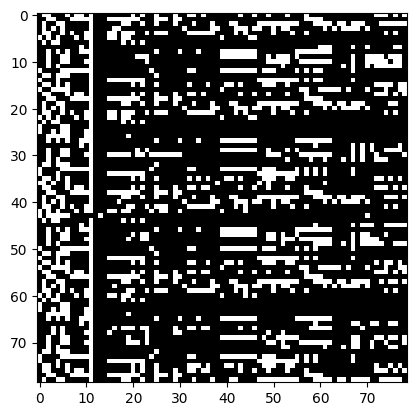

In [19]:
plt.imshow(images[0], cmap = 'gray')

In [20]:
np.save('../numpy_data/images',images)
np.save('../numpy_data/labels',labels)